In [2]:
import numpy                                   as np
import pandas                                  as pd
import matplotlib.pyplot                       as plt
import math
import random
from   sklearn                                 import ensemble
from   sklearn                                 import datasets
from   sklearn.utils                           import shuffle
from   sklearn.metrics                         import mean_squared_error
from   sklearn.datasets                        import load_boston
from   sklearn.model_selection                 import cross_val_score
from   sklearn.tree                            import DecisionTreeRegressor
from   sklearn.model_selection                 import train_test_split
from   sklearn.ensemble._gradient_boosting     import predict_stages
from   sklearn.ensemble._gradient_boosting     import predict_stage
from   abc                                     import abstractmethod
from   scipy.special                           import expit
from   sklearn.utils                           import check_array
from   sklearn.tree._tree                      import DTYPE
from   sklearn.tree._tree                      import TREE_LEAF
from   scipy.special                           import logsumexp
from   sklearn.utils                           import check_random_state
from   sklearn.ensemble.gradient_boosting      import ZeroEstimator
from   _aft_loss                               import loss, negative_gradient,hessian
import sys
import graphviz
sys.setrecursionlimit(10000)

In [2]:
from   sklearn.externals.six import StringIO  
from   IPython.display import Image  
from   sklearn.tree import export_graphviz
import pydotplus

In [3]:
class LossFunction(object):
    
    """Abstract base class for various loss functions.
    
    Parameters
    ----------
    n_classes : int
        Number of classes
    Attributes
    ----------
    K : int
        The number of regression trees to be induced;
        1 for regression and binary classification;
        ``n_classes`` for multi-class classification.
        
    """

    is_multi_class = False

    def __init__(self, n_classes):
        self.K = n_classes

    def init_estimator(self):
        
        """Default ``init`` estimator for loss function. """
        raise NotImplementedError()
    
    @abstractmethod
    def __call__(self, y_lower, y_higher,pred,dist,sigma,metrics,sample_weight=None):
        
        """Compute the loss.
        Parameters
        ----------
        y : array, shape (n_samples,)
            True labels
        pred : array, shape (n_samples,)
            Predicted labels
        sample_weight : array-like, shape (n_samples,), optional
            Sample weights.
        """

    @abstractmethod
    def negative_gradient(self, y_lower, y_higher, pred,dist,sigma, **kargs):
        
        """Compute the negative gradient.
        Parameters
        ----------
        y : array, shape (n_samples,)
            The target labels.
        pred : array, shape (n_samples,)
            The predictions.
        """


    def update_terminal_regions(self, tree, X, y_lower,y_higher, residual, y_pred, dist, sigma, sample_weight, sample_mask, learning_rate=1.0):
        
        """Update the terminal regions (=leaves) of the given tree and
        updates the current predictions of the model. Traverses tree
        and invokes template method '_update_terminal_region'.
        Parameters
        ----------
        tree : tree.Tree
            The tree object.
        X : array, shape (n, m)
            The data array.
        y : array, shape (n,)
            The target labels.
        residual : array, shape (n,)
            The residuals (usually the negative gradient).
        y_pred : array, shape (n,)
            The predictions.
        sample_weight : array, shape (n,)
            The weight of each sample.
        sample_mask : array, shape (n,)
            The sample mask to be used.
        learning_rate : float, default=0.1
            learning rate shrinks the contribution of each tree by
             ``learning_rate``.
        k : int, default 0
            The index of the estimator being updated.
        """
        
        # compute leaf for each sample in ''X''.
        
        terminal_regions                      = tree.apply(X)

        # mask all which are not in sample mask.
        masked_terminal_regions               = terminal_regions.copy()
        masked_terminal_regions[~sample_mask] = -1

        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            
            self._update_terminal_region(tree, masked_terminal_regions,
                                         leaf, X, y_lower, y_higher, residual, y_pred,dist,sigma, sample_weight)
        
        y_pred = y_pred + (learning_rate* tree.value[:, 0, 0].take(terminal_regions, axis=0))
        return y_pred

    @abstractmethod
    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y_lower,y_higher,
                                residual,pred,dist,sigma, sample_weight):
        
        """Template method for updating terminal regions (=leaves)."""

In [4]:
class ZeroEstimator:
    
    """An estimator that simply predicts zero.
    .. deprecated:: 0.21
        Using ``ZeroEstimator`` or ``init='zero'`` is deprecated in version
        0.21 and will be removed in version 0.23.
        
    """

    def fit(self, X, y_lower,y_higher,X_val, y_lower_val,y_higher_val, sample_weight=None):
        
        """Fit the estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training data
        y : numpy, shape (n_samples, n_targets)
            Target values. Will be cast to X's dtype if necessary
        sample_weight : array, shape (n_samples,)
            Individual weights for each sample
        """
        
        if np.issubdtype(y_lower.dtype, np.signedinteger):
            # classification
            self.n_classes = np.unique(y_lower).shape[0]
            if self.n_classes == 2:
                self.n_classes = 1
        else:
            # regression
            self.n_classes = 1

    def predict(self, X,X_val):
        """Predict labels
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Samples.
        Returns
        -------
        y : array, shape (n_samples,)
            Returns predicted values.
        """
        #check_is_fitted(self, 'n_classes')

        y = np.empty((X.shape[0], self.n_classes), dtype=np.float64)
        y.fill(0.0)
        
        y_val = np.empty((X_val.shape[0], self.n_classes), dtype=np.float64)
        y_val.fill(0.0)
        return y,y_val

    def predict_proba(self, X):
        return self.predict(X)

In [5]:
class AFT(LossFunction):
    """Cox Partial Likelihood"""

    def __call__(self, y_lower, y_higher, y_pred, dist, sigma, metrics, sample_weight=None):
        """Compute the partial likelihood of prediction ``y_pred`` and ``y``."""
        # TODO add support for sample weights
        return loss(y_lower, y_higher, y_pred.ravel(),dist, sigma,metrics)

    def negative_gradient(self, y_lower, y_higher, y_pred,dist,sigma,k=0,sample_weight=None, **kwargs):
        """Negative gradient of partial likelihood
        Parameters
        ---------
        y : tuple, len = 2
            First element is boolean event indicator and second element survival/censoring time.
        y_pred : np.ndarray, shape=(n,):
            The predictions.
        """
        ret = negative_gradient(y_lower, y_higher, y_pred.ravel(), dist, sigma)
        if sample_weight is not None:
            ret *= sample_weight
        return ret

    def init_estimator(self):  # pragma: no cover
        return ZeroEstimator()


    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y_lower,y_higher,
                                residual, pred, dist, sigma, sample_weight):
        
        """Least squares does not need to update terminal regions"""
        
        """Make a single Newton-Raphson step.
        our node estimate is given by:
            sum(w * gradient) / sum(w * hessian)
            
        """
        
        hess            = np.array(hessian(y_lower, y_higher, pred, dist, sigma))
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual        = residual.take(terminal_region, axis=0)
        hess            = hess.take(terminal_region, axis=0)
        sample_weight   = sample_weight.take(terminal_region, axis=0)
        pred            = pred.take(terminal_region, axis=0)

        numerator       = np.sum(sample_weight * residual)
        denominator     = np.sum(sample_weight * hess)

        # prevents overflow and division by zero
        
        if abs(denominator) < 1e-2:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator/denominator

In [6]:
def _random_sample_mask(n_total_samples,n_total_in_bag, random_state):
    
    """Create a random sample mask where ``n_total_in_bag`` elements are set.
    Parameters
    ----------
    n_total_samples : int
        The length of the resulting mask.

    n_total_in_bag : int
        The number of elements in the sample mask which are set to 1.
        
    random_state : np.RandomState
        A numpy ``RandomState`` object.

    Returns
    -------
    sample_mask : np.ndarray, shape=[n_total_samples]
         An ndarray where ``n_total_in_bag`` elements are set to ``True``
         the others are ``False``.
    """
    
    #random_state = np.random.RandomState(random_state)
    rand         = random_state.rand(n_total_samples)
    sample_mask  = np.zeros((n_total_samples,), dtype=np.bool)
    n_bagged     = 0
    
    for i in range(n_total_samples):
        
        if rand[i] * (n_total_samples - i) < (n_total_in_bag - n_bagged):
            sample_mask[i] = 1
            n_bagged += 1
            
    return sample_mask

In [7]:
#Difference between Attributes and Parameters

class BaseGradientBoosting():
    """Abstract base class for Gradient Boosting. """

    @abstractmethod
    def __init__(self, loss, learning_rate, n_estimators, criterion,
                 min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
                 max_depth, min_impurity_decrease, min_impurity_split,
                 init, subsample, max_features,
                 random_state, alpha=0.9, verbose=0, max_leaf_nodes=None,
                 warm_start=False, presort='auto', validation_fraction=0.25,
                 n_iter_no_change=None,metrics = 'logloss', Nestrov=False,dist='normal',sigma =1,
                 tol=1e-4):
        
        #Initial = 1
        self.n_estimators             = n_estimators + 1
        self.learning_rate            = learning_rate
        self.loss                     = loss
        self.criterion                = criterion
        self.min_samples_split        = min_samples_split
        self.min_samples_leaf         = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.subsample                = subsample
        self.max_features             = max_features
        self.max_depth                = max_depth
        self.min_impurity_decrease    = min_impurity_decrease
        self.min_impurity_split       = min_impurity_split
        self.init                     = init
        self.random_state             = random_state
        self.alpha                    = alpha
        self.verbose                  = verbose
        self.max_leaf_nodes           = max_leaf_nodes
        self.warm_start               = warm_start
        self.presort                  = presort
        self.validation_fraction      = validation_fraction
        self.n_iter_no_change         = n_iter_no_change
        self.tol                      = tol
        self.Nestrov                  = Nestrov
        self.dist                     = dist
        self.sigma                    = sigma
        self.metrics                  = metrics

    #Very Important loss class is defined here.
    
    def _init_state(self):
        
        self.estimators_    = np.empty((self.n_estimators, self.loss_.K),dtype=np.object)
        self.fitted_        = np.empty((self.n_estimators, self.loss_.K),dtype=np.object)
        self.prev_valid_    = np.empty((self.n_estimators, self.loss_.K),dtype=np.object)
        self.train_score_   = np.zeros((self.n_estimators, ),dtype=np.float64)
        self.valid_score_   = np.zeros((self.n_estimators, ),dtype=np.float64)
        self.random_state   = check_random_state(self.random_state)
        
        if self.Nestrov == True:
            
            self.g_fitted_      = np.empty((self.n_estimators, self.loss_.K),dtype=np.object)
            self.g_prev_valid_  = np.empty((self.n_estimators, self.loss_.K),dtype=np.object)
            self.lamb           = np.zeros((self.n_estimators,),dtype=np.float64)
            self.gamma          = np.zeros((self.n_estimators,),dtype=np.float64)
            self.gamma[0]       = 1
            
            for i in range(1,self.n_estimators):
                self.lamb[i] = 0.5*(1+math.sqrt(1+4*self.lamb[i-1]**2))
                
            for i in range(1,self.n_estimators-1):
                self.gamma[i] = (1-self.lamb[i])/self.lamb[i+1]
                
        
        #do oob?
        if self.init is None:
            self.init_ = self.loss_.init_estimator()
        elif isinstance(self.init, str):
            self.init_ = INIT_ESTIMATORS[self.init]()
        else:
            self.init_ = self.init

        """Initialize model state and allocate model state data structures. """

        if self.subsample < 1.0:
            self.oob_improvement_ = np.zeros((self.n_estimators),dtype=np.float64)
    
    def _check_params(self):
        
        """Check validity of parameters and raise ValueError if not valid. """
        
        
        if self.loss == 'aft':
            self.loss_ =  AFT(1)
            

    def _fit_stage(self, i, X, y_lower, y_higher, sample_weight, sample_mask, random_state):
        
        """Fit another stage of ``n_classes_`` trees to the boosting model. """
        
        assert sample_mask.dtype == np.bool
        loss       = self.loss_
        #original_y = y_lower
        pred       = np.zeros((X.shape[0],self.loss_.K),dtype=np.float64)
        
        for k in range(loss.K):
            if self.Nestrov == True:
                pred[:,k] = self.g_fitted_[i-1,k]    
            else:
                pred[:,k] = self.fitted_[i-1,k]
        
        for k in range(loss.K):
   
            residual = loss.negative_gradient(y_lower,y_higher,pred,self.dist,self.sigma,k=k,sample_weight=sample_weight)
        
            # induce regression tree on residuals
            tree     = DecisionTreeRegressor(
                                            criterion                 = self.criterion,
                                            splitter                  = 'best',
                                            max_depth                 = self.max_depth,
                                            min_samples_split         = self.min_samples_split,
                                            min_samples_leaf          = self.min_samples_leaf,
                                            min_weight_fraction_leaf  = self.min_weight_fraction_leaf,
                                            min_impurity_decrease     = self.min_impurity_decrease,
                                            min_impurity_split        = self.min_impurity_split,
                                            max_features              = self.max_features,
                                            max_leaf_nodes            = self.max_leaf_nodes,
                                            random_state              = random_state,
                                            presort                   = self.presort
                                            )

            if self.subsample < 1.0:
                # no inplace multiplication!
                sample_weight = sample_weight * sample_mask.astype(np.float64)
                

            tree.fit(X, residual, sample_weight=sample_weight)
            
            #dot_data = StringIO()
            #export_graphviz(tree, out_file=dot_data,  
            #                filled=True, rounded=True,
            #                special_characters=True)
            #graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            #Image(graph.create_png())
            #filename = "tree"+str(i)+".png"
            #graph.write_png(filename)

            # update tree leaves    
            if self.Nestrov == True:
                
                y_pred                  = self.g_fitted_[i-1,k]
                self.fitted_[i,k]       = loss.update_terminal_regions(tree.tree_, X, y_lower, y_higher, residual, y_pred,self.dist,self.sigma,sample_weight, sample_mask,self.learning_rate)
                self.g_fitted_[i,k]     = (1-self.gamma[i-1])*self.fitted_[i,k]+self.gamma[i-1]*self.fitted_[i-1,k]
                
            else:
                y_pred            = self.fitted_[i-1,k]
                self.fitted_[i,k] = loss.update_terminal_regions(tree.tree_, X, y_lower,y_higher, residual, y_pred,self.dist,self.sigma,sample_weight, sample_mask,self.learning_rate)

            # add tree to ensemble
            self.estimators_[i, k] = tree
    
    def n_features(self):
        return self.n_features_
    
    def _validate_y(self, y, sample_weight):
        self.classes_    = np.unique(y)
        self.n_classes_  = len(self.classes_)
        return y
    
    def _fit_stages(self, X, y_lower, y_higher,sample_weight, random_state,
                    X_val, y_lower_val, y_higher_val,sample_weight_val,begin_at_stage=0):
        
        
        n_samples    = X.shape[0]
        do_oob       = self.subsample < 1.0
        sample_mask  = np.ones((n_samples, ), dtype=np.bool)
        n_inbag      = max(1, int(self.subsample * n_samples))
        loss_        = self.loss_
        
        # create one-hot label encoding
        pred         = np.zeros((n_samples, self.loss_.K), dtype=np.float64)
        pred_val     = np.zeros((X_val.shape[0], self.loss_.K), dtype=np.float64)
        
        for k in range(self.loss_.K):
            pred[:,k] = self.fitted_[0,k]
            pred_val[:,k] = self.prev_valid_[0,k]
            
        if do_oob:
            
            sample_mask = _random_sample_mask(n_samples, n_inbag, random_state)
            self.train_score_[0] = loss_(y_lower[sample_mask],y_higher[sample_mask],pred[sample_mask],self.dist,self.sigma,self.metrics,sample_weight[sample_mask])
            
        else:
            
            self.train_score_[0] = loss_(y_lower,y_higher,pred,self.dist,self.sigma,self.metrics,sample_weight)
        self.valid_score_[0] = loss_(y_lower_val,y_higher_val,pred_val,self.dist,self.sigma,self.metrics,sample_weight_val)

        # perform boosting iterations
        # validation loss performance
        
        for i in range(begin_at_stage, self.n_estimators):

            # subsampling
            if do_oob:
                sample_mask = _random_sample_mask(n_samples, n_inbag, random_state)
                
            # fit next stage of trees
            self._fit_stage(i, X, y_lower,y_higher, sample_weight,sample_mask, random_state)

            if self.Nestrov == True:
                
                score = np.zeros((X_val.shape[0], self.loss_.K), dtype=np.float64)
                
                for k in range(self.loss_.K):
                    score[:,k] = self.g_prev_valid_[i-1,k].copy()
                    
                predict_stage(self.estimators_, i, X_val, self.learning_rate, score)

                for k in range(self.loss_.K):
                    self.prev_valid_[i,k] = score[:,k].copy()
                    
                for k in range(self.loss_.K):
                    self.g_prev_valid_[i,k] = (1-self.gamma[i-1])*self.prev_valid_[i,k]+self.gamma[i-1]*self.prev_valid_[i-1,k]
            else:
                
                score = np.zeros((X_val.shape[0], self.loss_.K), dtype=np.float64)
                for k in range(self.loss_.K):
                    score[:,k] = self.prev_valid_[i-1,k].copy()

                predict_stage(self.estimators_, i, X_val, self.learning_rate, score)
                
                for k in range(self.loss_.K):
                    self.prev_valid_[i,k] = score[:,k].copy()

            for k in range(self.loss_.K):
                
                pred[:,k] = self.fitted_[i,k]
                pred_val[:,k] = self.prev_valid_[i,k]
            
            if do_oob:
                self.train_score_[i] = loss_(y_lower[sample_mask],y_higher[sample_mask],pred[sample_mask],self.dist,self.sigma,self.metrics,sample_weight[sample_mask])
            else:
                self.train_score_[i] = loss_(y_lower,y_higher,pred,self.dist,self.sigma,self.metrics,sample_weight)
   
            self.valid_score_[i] = loss_(y_lower_val,y_higher_val,pred_val,self.dist,self.sigma,self.metrics,sample_weight_val)
    
        return i + 1

    
    def fit(self, X, y_lower,y_higher, X_val = None,y_lower_val=None, y_higher_val=None,sample_weight=None):
        
        # Check input
        n_samples, self.n_features_ = X.shape
        #y_lower                     = self._validate_y(y_lower, sample_weight)
        #y_higher                    = self._validate_y(y_higher, sample_weight)
        X                           = check_array(X, dtype=DTYPE, order="C",  accept_sparse='csr')
        sample_weight               = np.ones(n_samples, dtype=np.float32)
        
        if X_val is None:
            X, X_val, y_lower, y_lower_val,y_higher,y_higher_val,sample_weight, sample_weight_val \
            = train_test_split(X, y_lower,y_higher,sample_weight,random_state=self.random_state,test_size=self.validation_fraction)
            self._check_params()
            self._init_state()
        else:
            sample_weight_val = np.ones(X_val.shape[0], dtype=np.float32)

        # fit initial model - FIXME make sample_weight optional
        #For Binomial       - init_ = LogOddsEstimator
        #For Multinomial    - init_ = PriorProbabilityEstimator

        self.init_.fit(X, y_lower,y_higher, X_val, y_lower_val,y_higher_val, sample_weight)
        # init predictions and update in the inplace self
        initial_pred,initial_val_pred  = self.init_.predict(X,X_val)
        
        for k in range(self.loss_.K):
            self.fitted_[0,k], self.prev_valid_[0,k]          = initial_pred[:,k],initial_val_pred[:,k]
            if self.Nestrov == True:
                self.g_fitted_[0,k], self.g_prev_valid_[0,k]  = initial_pred[:,k],initial_val_pred[:,k]

        begin_at_stage = 1
        # fit the boosting stages
        
        n_stages = self._fit_stages(X, y_lower,y_higher, sample_weight, self.random_state,
                                    X_val, y_lower_val,y_higher_val, sample_weight_val,begin_at_stage)
        # change shape of arrays after fit (early-stopping or additional ests)
        self.n_estimators_ = n_stages
        
        return self
    
    def _make_estimator(self, append=True):
        # we don't need _make_estimator
        raise NotImplementedError()
        
        
    def _init_decision_function(self, X):
        
        """Check input and compute prediction of ``init``. """
        #self._check_initialized()
        #X = self.estimators_[0, 0]._validate_X_predict(X, check_input=True)
        if X.shape[1] != self.n_features_:
            raise ValueError("X.shape[1] should be {0:d}, not {1:d}.".format(
                self.n_features_, X.shape[1]))
        score = self.init_.predict(X).astype(np.float64)
        
        return score
    
    def _decision_function(self, X):
        
        # for use in inner loop, not raveling the output in single-class case,
        # not doing input validation.
        
        score = self._init_decision_function(X)
        predict_stages(self.estimators_, X, self.learning_rate, score)
        return score

    def _staged_decision_function(self, X):
        
        #X = check_array(X, dtype=DTYPE, order="C",  accept_sparse='csr')
        
        score = self._init_decision_function(X)
        for i in range(self.estimators_.shape[0]):
            predict_stage(self.estimators_, i, X, self.learning_rate, score)
            yield score.copy()
    


class GradientBoostingClassifier(BaseGradientBoosting):

    _SUPPORTED_LOSS = ('survival')

    def __init__(self, loss='aft', learning_rate=0.1, n_estimators=100,
                 subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.,
                 max_depth=3, min_impurity_decrease=0.,
                 min_impurity_split=None, init=None,
                 random_state=None, max_features=None, verbose=0,
                 max_leaf_nodes=None, warm_start=False,
                 presort='auto', validation_fraction=0.25,
                 n_iter_no_change=None,Nestrov=False,metrics = 'logloss',dist='normal',sigma=1,tol=1e-4):

        super().__init__(
            loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
            criterion=criterion, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_depth=max_depth, init=init, subsample=subsample,
            max_features=max_features,
            random_state=random_state, verbose=verbose,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            min_impurity_split=min_impurity_split,
            warm_start=warm_start, presort=presort,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,Nestrov=Nestrov,metrics=metrics,
            dist=dist,sigma=sigma,tol=tol)

    def _validate_y(self, y, sample_weight):
        #check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        n_trim_classes = np.count_nonzero(np.bincount(y, sample_weight))
        if n_trim_classes < 2:
            raise ValueError("y contains %d class after sample_weight "
                             "trimmed classes with zero weights, while a "
                             "minimum of 2 classes are required."
                             % n_trim_classes)
        self.n_classes_ = len(self.classes_)
        return y

    def decision_function(self, X):
        X = check_array(X, dtype=DTYPE, order="C",  accept_sparse='csr')
        score = self._decision_function(X)
        if score.shape[1] == 1:
            return score.ravel()
        return score

    #def staged_decision_function(self, X):
    #    
    #    yield from self._staged_decision_function(X)

    def predict(self, X):
       
        score     = self.decision_function(X)
        decisions = self.loss_._score_to_decision(score)
        return self.classes_.take(decisions, axis=0)

    def staged_predict(self, X):
       
        for score in self._staged_decision_function(X):
            decisions = self.loss_._score_to_decision(score)
            yield self.classes_.take(decisions, axis=0)

    def predict_proba(self, X):
        
        score = self.decision_function(X)
        try:
            return self.loss_._score_to_proba(score)
        except NotFittedError:
            raise
        except AttributeError:
            raise AttributeError('loss=%r does not support predict_proba' %
                                 self.loss)

    def predict_log_proba(self, X):
        
        proba = self.predict_proba(X)
        return np.log(proba)

    def staged_predict_proba(self, X):
       
        try:
            for score in self._staged_decision_function(X):
                yield self.loss_._score_to_proba(score)
                
        except NotFittedError:
            raise
        except AttributeError:
            raise AttributeError('loss=%r does not support predict_proba' %
                                 self.loss)

In [8]:
##############################################################################
def data_creation(file_name,K=5):
    
    df_train   = pd.read_csv(file_name)
    y          = list(df_train['Y'])
    req_cols   = [i for i in df_train.columns if i != 'Y']
    X          = np.array(df_train[req_cols])
    y_median   = np.percentile(y, 50) # return 50th percentile, e.g median.
    bin_y      = list(map(lambda x : 0 if x < y_median else 1,y))

    percentile = np.percentile(y, np.arange(0, 100, 100/K)) # deciles
    multi_y    = list(map(lambda x : 0 if x >= percentile[0] and x< percentile[1] else 1 if x >= percentile[1] and x< percentile[2] else 2 if x >= percentile[2] and x< percentile[3] else 3,y))
    
    return X,y,bin_y,multi_y

def chart_creation(gb,chart_title,chart_name):
    
    min_valid = round(np.min(gb.valid_score_),4)
    min_train = round(np.min(gb.train_score_),4)
    min_iter  = round(np.nanargmin(gb.valid_score_),0)

    textstr = '\n'.join((
                    'Min Train = %.2f' % (min_train, ),
                    'Min Valid = %.2f' % (min_valid, ),
                    'Min Iter  = %.2f' % (min_iter, )))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5,edgecolor="black")
    
    fig,ax1       = plt.subplots()
    ax2           = ax1.twinx()

    ln1 = ax1.plot(gb.train_score_,color='blue',label='Training')
    ln2 = ax2.plot(gb.valid_score_,color='orange',label='Validation')
    
    #ax1.axvline(x=np.nanargmin(gb.valid_score_),color='r')
    #ax2.axhline(y=np.min(gb.valid_score_),color='b')
    lns = ln1 + ln2
    
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower left',fancybox='round', facecolor='wheat',fontsize=8)
    
    ax1.set_xlabel("Number of Iterations(Trees)")
    ax1.set_ylabel("Training Negative Likelihood(Loss)")
    ax2.set_ylabel("Validation Negative Likelihood(Loss)")
    #ax1.legend(["Training","Validation"],loc='lower left',fancybox='round', facecolor='wheat',fontsize=8)
    # place a text box in upper left in axes coords
    ax2.text(0.7, 0.90, textstr, transform=ax1.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    plt.title(chart_title)
    plt.show()
    fig.savefig(chart_name)
    
def generate_result(X,y_lower,y_higher,param,X_val=None,y_lower_val=None,y_higher_val=None):
    
    gb_manual = GradientBoostingClassifier(**param)
    gb_manual.fit(X,y_lower,y_higher,X_val,y_lower_val,y_higher_val)
    
    return gb_manual    

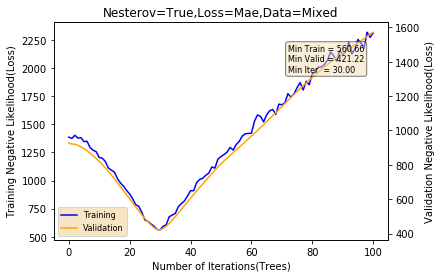

In [17]:
if __name__ == "__main__":
    
    data     = pd.read_csv('simulate_survival.csv')
    X        = data[['x1','x2','x3']]
    y_lower  = data['left']
    y_higher = data['right']

    param    = {'n_estimators' : 100,'learning_rate': 0.01,'Nestrov' : True,'subsample': 0.5,'min_samples_split': 10,
                 'max_depth': 2,'metrics':'mae','dist':'normal','sigma':2,'random_state' : 0}

    gb_manual = generate_result(X,y_lower,y_higher,param)
    chart_creation(gb_manual,'Nesterov=True,Loss=Mae,Data=Mixed','Nesterov_True_Loss_Mae_Data_Mixed.png')

In [3]:
data     = pd.read_csv('../../data/ATAC_JV_adipose/inputs.csv')

In [6]:
colnames = data.isna().sum()